# Scientific Concept Evolution Tracker

At this point I feel like I've experimented enough with this and now I can implement something that makes sense to me. This notebook will serve as a source of documentation for the implementation of this project. I will document my thoughts of how I will approach building this project (which I will refer to as SCET going forward).

The goal of this project is as follows. Given a scientific concept (i.e., the query) such as "Corona", how can we

1. Find the most relevant papers from different eras that indicate "shifts" in the contextual meaning of the term.
    - Before 2020, "Corona" would likely be associated with [corona discharge](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Corona_discharge&ved=2ahUKEwid06-J3rCRAxWkOzQIHcWSLkEQFnoECBoQAQ&usg=AOvVaw0VzdLEHNdHES3fu02lie58) or [stellar corona](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Stellar_corona&ved=2ahUKEwid06-J3rCRAxWkOzQIHcWSLkEQFnoECBsQAQ&usg=AOvVaw0VxSEegT2Km54Q3L-7KW9Z), where nowadays it is more associated with virology
2. Design a mechanism that can re-rank those papers based on how "pivotal" it was for the history of the concept

## Getting Data

As of 2022 there are over 5.14 million academic articles published per year ([WordsRated](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://wordsrated.com/number-of-academic-papers-published-per-year/&ved=2ahUKEwiQqbOC3bCRAxWMCjQIHWSxBiMQFnoECCEQAQ&usg=AOvVaw0fqfpJLzxavGNIlmsVlrxX)), and the cumulative total is estimated to be over 50 million ([ResearchGate](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.researchgate.net/publication/229062236_Article_50_million_An_estimate_of_the_number_of_scholarly_articles_in_existence&ved=2ahUKEwiQqbOC3bCRAxWMCjQIHWSxBiMQFnoECB8QAQ&usg=AOvVaw112p_TvuMPfBcb1QdINC74)).

There are various sources where we can obtain publication data. I arbitrarily chose to source my data from [arXiv](https://arxiv.org/), mainly because we can do a bulk download of the metadata of ~2.8m publications. We can do this via [Kaggle](https://www.kaggle.com/datasets/Cornell-University/arxiv) or directly through their Google Cloud Storage bucket at `gs://arxiv-dataset/metadata-v5/arxiv-metadata-oai.json`, either option is ~4GB. Using this, we can get a publication's
- `id` (the arXiv identifier for the publication)
- `doi`, although this seems to be inconsistently populated
- `category` (all categories listed [here](https://arxiv.org/category_taxonomy))
- `title`
- `abstract`
- `authors`

There are two features that this dataset does not contain: full-text and citations. Of course, these properties seem to be the most difficult to obtain for a publication. Full-text is justifiably hard to obtain because it is relatively difficult to extract text from PDFs. Citations are another problem in itself. I am going to try to get by without using full-text and citations, although I acknowledge that I may have to factor these into the system.

> *Note:* I am going to use [Attention Is All You Need](https://arxiv.org/abs/1706.03762) as an example throughout this notebook. It serves as an easy benchmark. If I query `Transformer` or `Transformer Attention`, then this paper definitely should be the most pivotal...

I have already ingested the arXiv metadata into a Postgres database (see [ingest_metadata.py](../scripts/ingest_metadata.py)). I don't want to experiment building SCET with all of this data (my hardware does not have unlimited memory and I do not have all the time in the world), so I will use a subset of this data in hopes that it will scale.

I will choose this subset by sampling over time and categories. Including the available time range will allow us to test evolution of a concept, and the variety of categories should put enough noise into the corpus to make it non-trivial.

In [1]:
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
load_dotenv()

DB_USER = os.environ["POSTGRES_USER"]
DB_PASSWORD = os.environ["POSTGRES_PASSWORD"]
DB_HOST = os.environ["POSTGRES_HOST"]
DB_PORT = os.environ["POSTGRES_PORT"]
DB_NAME = os.environ["POSTGRES_DB"]
DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)
with engine.connect():
    print(f"Connected to PostgreSQL")

Connected to PostgreSQL


In [2]:
sql = '''
SELECT DISTINCT
	primary_category
FROM
	papers
ORDER BY
	primary_category
'''
with engine.connect() as connection:
    results = connection.execute(text(sql)).fetchall()
    categories = [result.primary_category for result in results]
print(f"Total categories: {len(categories)}")
categories[:5]

Total categories: 172


['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph']

In [3]:
sql = '''
SELECT
	min(published_date) AS min_date,
	max(published_date) AS max_date
FROM
	papers
'''
with engine.connect() as connection:
    min_date, max_date = connection.execute(text(sql)).fetchone()
print(f"Dates range from {min_date} to {max_date}")

Dates range from 1986-04-25 to 2025-11-26


### Generate Sample Data

We will use a materialized view to store our sample data (this way it only needs to be generated once).

In [4]:
sql = '''
CREATE MATERIALIZED VIEW IF NOT EXISTS sample_papers AS
WITH
	params AS (
		SELECT
			5000 AS target_size,
			50 AS num_time_buckets,
			min(published_date) AS min_date,
			max(published_date) AS max_date
		FROM papers
	),
	global_stats AS (
		-- Calculate global distribution of primary_category
		SELECT
			primary_category,
			COUNT(*)::NUMERIC / SUM(COUNT(*)) OVER () AS global_ratio
		FROM papers
		WHERE
			published_date BETWEEN ( SELECT min_date FROM params ) AND ( SELECT max_date FROM params )
		GROUP BY primary_category
	),
	binned_data AS (
		-- assign every row to a time bucket with global distributions
		SELECT
			t.*,
			gs.global_ratio,
			-- equal-width time buckets
			width_bucket(
				EXTRACT( epoch FROM t.published_date ),
				EXTRACT( epoch FROM ( SELECT min_date FROM params) ),
				EXTRACT( epoch FROM (SELECT max_date FROM params) ),
				(SELECT num_time_buckets FROM params)
			) AS bucket_id
		FROM
			papers t
			JOIN global_stats gs ON t.primary_category = gs.primary_category
		WHERE
			t.published_date BETWEEN ( SELECT min_date FROM params ) AND ( SELECT max_date FROM params )
	),
	targets AS (
		-- calculate exactly how many rows we need for each (Bucket, Category) pair
		-- determine via (Total Sample / Total Buckets) * Category Frequency
		SELECT
			*,
			(
				(
					SELECT target_size
					FROM params
				) / (
					SELECT num_time_buckets
					FROM params
				)::NUMERIC
			) * global_ratio AS exact_target
		FROM binned_data
	),
	ranked_data AS (
		-- shuffle rows randomly within their specific (Bucket, Category) group
		SELECT
			*,
			ROW_NUMBER() OVER (
				PARTITION BY
					bucket_id,
					primary_category
				ORDER BY
					-- ensure that Attention Is All You Need is included
					CASE WHEN arxiv_id = '1706.03762' THEN 0 ELSE 1 END ASC,
					RANDOM()
			) AS rnk
		FROM targets
	)
SELECT * FROM ranked_data
WHERE
	rnk <= floor(exact_target) + (
		CASE WHEN RANDOM() < (exact_target - floor(exact_target)) THEN 1 ELSE 0 END
	);
'''

with engine.connect() as connection:
    result = connection.execute(text(sql))
    connection.commit()
print("Materialized view created")

Materialized view created


In [5]:
import pandas as pd

sql = '''
SELECT
	arxiv_id,
	title,
	abstract,
	primary_category,
	published_date,
	doi
FROM
	sample_papers
ORDER BY
	published_date
'''
with engine.connect() as connection:
    results = connection.execute(text(sql))
    papers = pd.DataFrame(results.fetchall())
papers.shape

(3606, 6)

In [6]:
papers.head()

,arxiv_id,title,abstract,primary_category,published_date,doi
0,hep-th/9108028,Applied Conformal Field Theory,These lectures consisted of an elementary intr...,hep-th,1988-11-11,None
1,math/9201207,The Rademacher cotype of operators from $l_\in...,We show that for any operator $T:l_\infty^N\to...,math.FA,1989-11-17,None
2,cs/9301111,Nested satisfiability,"A special case of the satisfiability problem, ...",cs.CC,1990-01-01,None
3,math/9201303,Stable husbands,Suppose $n$ boys and $n$ girls rank each other...,math.CO,1990-01-01,None
4,math/9201271,Conformal dynamics problem list,This is a list of unsolved problems given at t...,math.DS,1990-01-18,None


## Generating Embeddings

Now that we have our sample data, we will convert the raw text into vector representations that we can search with. We will use a hybrid embedding strategy to capture both semantic meaning and specific keyword matches.

1.  *Dense Embeddings*: [SPECTER2](https://huggingface.co/allenai/specter2_base) is a model specifically trained on scientific citations. We will use it for capturing the high-level semantic meaning of a paper. If we query "Corona", SPECTER2 will help us find papers about viral structures or stellar atmospheres (depending on the context), rather than just keyword matches
2.  *Sparse Embeddings*: [SPLADE](https://github.com/naver/splade) generates sparse vectors that function like a "learned bag-of-words". It performs expansion (adding relevant terms not present in the text) and re-weighting. This is useful for maintaining keyword precision

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

# load dense model (SPECTER2)
dense_model_name = 'allenai/specter2_base'
dense_model = SentenceTransformer(dense_model_name).to(device)
print(f"Loaded Dense Model: {dense_model_name}")

# load sparse model (SPLADE)
sparse_model_id = 'naver/splade-cocondenser-ensembledistil'
sparse_tokenizer = AutoTokenizer.from_pretrained(sparse_model_id)
sparse_model = AutoModelForMaskedLM.from_pretrained(sparse_model_id).to(device)
print(f"Loaded Sparse Model: {sparse_model_id}")

No sentence-transformers model found with name allenai/specter2_base. Creating a new one with mean pooling.


Using device: mps
Loaded Dense Model: allenai/specter2_base
Loaded Dense Model: allenai/specter2_base
Loaded Sparse Model: naver/splade-cocondenser-ensembledistil
Loaded Sparse Model: naver/splade-cocondenser-ensembledistil


In [8]:
from tqdm import tqdm
import numpy as np
from ast import literal_eval

def generate_dense_embeddings(texts):
    return dense_model.encode(texts, convert_to_tensor=True, normalize_embeddings=True)

def generate_sparse_embedding(text):
    tokens = sparse_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        output = sparse_model(**tokens)
    
    # SPLADE aggregation (max pooling over log(1 + relu(logits)))
    logits = output.logits
    values, _ = torch.max(
        torch.log(1 + torch.relu(logits)) * tokens.attention_mask.unsqueeze(-1), 
        dim=1
    )
    
    # Convert to dict ~ {token_id: weight}
    vector = values.squeeze().cpu().numpy()
    non_zero_indices = vector.nonzero()[0]
    return {int(idx): float(vector[idx]) for idx in non_zero_indices}

def generate_embeddings(paper_df: pd.DataFrame, load_csv: bool = True, save_csv: bool = True):
    csv_path = 'data/sample_papers_with_embeddings.csv'
    
    if load_csv:
        print("Loading from CSV...")
        try:
            def parse_dense_vector_csv(s):
                s = s.replace('[', '').replace(']', '').replace('\n', ' ')
                return np.fromstring(s, sep=' ', dtype=np.float32)
            csv_df = pd.read_csv(csv_path)
            csv_df.dense_vector = csv_df.dense_vector.apply(parse_dense_vector_csv)
            csv_df.sparse_vector = csv_df.sparse_vector.apply(literal_eval)
            csv_df.published_date = csv_df.published_date.apply(pd.to_datetime)
            return csv_df
        except Exception as e:
            print(f"Failed to load from CSV: {e}")
    
    df = paper_df.copy()

    print("Generating Dense Embeddings...")
    sep_token = dense_model.tokenizer.sep_token
    df['specter_input'] = df['title'] + sep_token + df['abstract']
    df['dense_vector'] = list(
        generate_dense_embeddings(df['specter_input'].tolist()).cpu().numpy()
    )

    print("Generating Sparse Embeddings...")
    tqdm.pandas()
    df['sparse_vector'] = df['specter_input'].progress_apply(generate_sparse_embedding)

    print("Embeddings generated.")
    
    if save_csv:
        papers.to_csv(csv_path, index=False)
        print(f"Saved embeddings to {csv_path}")
    
    return df

embedded_papers = generate_embeddings(papers)
embedded_papers[['arxiv_id', 'dense_vector', 'sparse_vector']].head()

Loading from CSV...


,arxiv_id,dense_vector,sparse_vector
0,hep-th/9108028,"[0.022522805, 0.029086195, 0.005951591, 0.0440...","{1012: 0.004072231240570545, 1016: 0.634854495..."
1,math/9201207,"[0.03122084, 0.03126316, -0.00011172818, 0.025...","{1002: 1.6506469249725342, 1003: 0.30638721585..."
2,cs/9301111,"[0.043976273, 0.0058500934, 0.014620507, -0.00...","{1000: 0.3820948600769043, 1005: 0.00831570103..."
3,math/9201303,"[0.022883516, 0.02199802, -0.008349336, 0.0087...","{1002: 1.385781168937683, 1003: 0.347594857215..."
4,math/9201271,"[0.011540209, 0.0029417637, 0.011269698, 0.036...","{2001: 0.396415650844574, 2012: 0.000928447640..."


## Vector Database Setup (Milvus)

We will use [Milvus](https://milvus.io/) as the vector database to store our embeddings.

We need to define a schema for our collection. A key design choice here is a partition key. We want to be able to efficiently query papers from specific time periods/categories. By creating a partition key derived from the `Year` and `Category` columns, Milvus can physically group related data, speeding up our temporal queries.

We use `Int64` for the `paper_id` (Primary Key) instead of the raw string `arxiv_id` for performance (lookup). We do not use `VarChar` since we have no guarantee on the length of the arXiv ID. We will also store the original `arxiv_id` as a string field for easier debugging and retrieval, even though we are not using it as the primary key.

**Schema:**
*   `paper_id` (Int64): A 64-bit hashed integer version of the arXiv ID (Primary Key)
*   `arxiv_id` (VarChar): The original arXiv ID string (for debugging/reference)
*   `dense_vector` (FloatVector, 768): The SPECTER2 embedding
*   `sparse_vector` (SparseFloatVector): The SPLADE embedding
*   `publication_year` (Int16): For filtering
*   `partition_key` (Int64): Hash of `Year` + `Category`

In [9]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# Connect to Milvus
MILVUS_HOST = os.environ.get("MILVUS_HOST", "localhost")
MILVUS_PORT = os.environ.get("MILVUS_PORT", "19530")
connections.connect("default", host=MILVUS_HOST, port=MILVUS_PORT)
print(f"Connected to Milvus at {MILVUS_HOST}:{MILVUS_PORT}")

collection_name = "arxiv_diachronic_sample"

# Drop if exists to start fresh
if utility.has_collection(collection_name):
    print(f"Dropping existing collection: {collection_name}")
    utility.drop_collection(collection_name)

# Define Schema
fields = [
    FieldSchema(name="paper_id", dtype=DataType.INT64, is_primary=True, description="Hashed arXiv ID"),
    FieldSchema(name="arxiv_id", dtype=DataType.VARCHAR, max_length=32, description="Original arXiv ID"),
    FieldSchema(name="dense_vector", dtype=DataType.FLOAT_VECTOR, dim=768, description="SPECTER2 embedding"),
    FieldSchema(name="sparse_vector", dtype=DataType.SPARSE_FLOAT_VECTOR, description="SPLADE embedding"),
    FieldSchema(name="publication_year", dtype=DataType.INT16, description="Year for filtering"),
    FieldSchema(name="partition_key", dtype=DataType.INT64, is_partition_key=True, description="Hash of Year + Domain"),
]

schema = CollectionSchema(fields, "Diachronic ArXiv Collection")
collection = Collection(collection_name, schema)

# Create Indexes
print("Creating indexes...")
collection.create_index(field_name="dense_vector", index_params={
    "metric_type": "COSINE",
    "index_type": "HNSW",
    "params": {"M": 16, "efConstruction": 200}
})
collection.create_index(field_name="sparse_vector", index_params={
    "metric_type": "IP", # Inner Product is standard for sparse
    "index_type": "SPARSE_INVERTED_INDEX",
    "params": {"drop_ratio_build": 0.2}
})
collection.create_index(field_name="publication_year", index_name="year_index")

print(f"Collection '{collection_name}' created and indexed.")

Connected to Milvus at 10.182.207.119:19530
Dropping existing collection: arxiv_diachronic_sample
Creating indexes...
Creating indexes...
Collection 'arxiv_diachronic_sample' created and indexed.
Collection 'arxiv_diachronic_sample' created and indexed.


In [10]:
import hashlib

def hash_to_int64(s: str) -> int:
    """
    Generates a stable 64-bit integer hash from a string.
    We use MD5 and take the first 15 hex characters (60 bits) to ensure it fits 
    within a signed 64-bit integer (Milvus Int64 limit).
    """
    return int(hashlib.md5(s.encode()).hexdigest()[:15], 16)

def get_partition_key(year, domain_str) -> int:
    key_str = f"{year}_{domain_str}"
    return hash_to_int64(key_str)

def prepare_and_ingest(df, collection):
    insert_data = {
        "paper_id": [],
        "arxiv_id": [],
        "dense_vector": [],
        "sparse_vector": [],
        "publication_year": [],
        "partition_key": []
    }
    
    print(f"Preparing {len(df)} records for ingestion...")
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            # Generate IDs using 64-bit hash
            p_id = hash_to_int64(row['arxiv_id'])
            year = row['published_date'].year
            part_key = get_partition_key(year, row['primary_category'])
            
            insert_data["paper_id"].append(p_id)
            insert_data["arxiv_id"].append(str(row['arxiv_id']))
            insert_data["dense_vector"].append(row['dense_vector'])
            insert_data["sparse_vector"].append(row['sparse_vector'])
            insert_data["publication_year"].append(year)
            insert_data["partition_key"].append(part_key)
            
        except Exception as e:
            print(f"Error processing {row['arxiv_id']}: {e}")
            continue
            
    print("Inserting into Milvus...")
    collection.upsert([
        insert_data["paper_id"],
        insert_data["arxiv_id"],
        insert_data["dense_vector"],
        insert_data["sparse_vector"],
        insert_data["publication_year"],
        insert_data["partition_key"]
    ])
    
    collection.flush()
    print(f"Ingestion complete. Collection row count: {collection.num_entities}")

prepare_and_ingest(embedded_papers, collection)

Preparing 3606 records for ingestion...


100%|██████████| 3606/3606 [00:00<00:00, 49008.50it/s]

Inserting into Milvus...


Ingestion complete. Collection row count: 3606


## Hybrid Search Implementation

Now we can implement the search logic. We will use a hybrid search:
1.  *Dense vector search*: Finds semantically similar papers (good for concept matching)
2.  *Sparse vector search*: Finds keyword-based matches (good for precision)

We use a `WeightedRanker` to combine these scores. We can adjust the `alpha` parameter to weight dense vs. sparse importance.

Note: in our hybrid search, we perform two independent searches (Dense and Sparse) and then combine the results. If we set the limit too low (e.g., 10), a paper that is ranked 15th in Dense and 15th in Sparse might not be retrieved by *either* search, even though its combined score might be higher than the top results. To fix this, we fetch a larger pool of candidates (e.g., 200) from each method before reranking.

In [11]:
from pymilvus import AnnSearchRequest, WeightedRanker

def search_papers(
    query: str, 
    start_year: int = 1980, 
    end_year: int = 2025, 
    limit: int = 10, 
    alpha: float = 0.5
    ) -> pd.DataFrame:
    # embed query
    dense_vec = dense_model.encode([query], normalize_embeddings=True)[0].tolist()
    sparse_vec = generate_sparse_embedding(query)
    
    # create search requests
    # Fetch more candidates for individual searches
    candidate_limit = max(limit * 10, 100) 
    expr = f"publication_year >= {start_year} && publication_year <= {end_year}"
    dense_req = AnnSearchRequest(
        data=[dense_vec],
        anns_field="dense_vector",
        param={"metric_type": "COSINE", "params": {"nprobe": 10}},
        limit=candidate_limit,
        expr=expr
    )
    sparse_req = AnnSearchRequest(
        data=[sparse_vec],
        anns_field="sparse_vector",
        param={"metric_type": "IP", "params": {"drop_ratio_search": 0.2}},
        limit=candidate_limit,
        expr=expr
    )
    
    # perform search
    collection.load()
    res = collection.hybrid_search(
        reqs=[dense_req, sparse_req],
        rerank=WeightedRanker(alpha, 1-alpha), # alpha * Dense + (1-alpha) * Sparse
        limit=limit,
        output_fields=["arxiv_id", "publication_year"]
    )
    
    if not res:
        return pd.DataFrame()
    
    # format results
    results = [{
        "arxiv_id": hit.entity.get("arxiv_id"), 
        "score": hit.score, 
        "year": hit.entity.get("publication_year")
        } for hit in res[0]]
    results_df = pd.DataFrame(results)
    
    if results_df.empty:
        return results_df

    # join Milvus results with Postgres so they contain metadata
    ids_str = f"({ ", ".join("'" + results_df.arxiv_id + "'") })"
    sql = f"""
    SELECT arxiv_id, title, abstract, primary_category, published_date
    FROM papers WHERE arxiv_id IN {ids_str}
    """
    with engine.connect() as connection:
        meta_results = connection.execute(text(sql))
        metadata = pd.DataFrame(meta_results.fetchall())
        
    final_df = results_df.merge(metadata, on='arxiv_id')
    return final_df

query = "Transformer Attention"

attention_id = '1706.03762' # arXiv for Attention Is All You Need
print(f"Querying: '{query}'")
results = search_papers(query, start_year=2010, end_year=2024, alpha=0.5, limit=50)

# Check rank of target paper
if attention_id in results['arxiv_id'].values:
    rank = results[results['arxiv_id'] == attention_id].index[0] + 1
    score = results[results['arxiv_id'] == attention_id].score.values[0]
    print(f"Success! 'Attention Is All You Need' found at rank {rank} with score {score:.4f}")
else:
    print(f"Warning: 'Attention Is All You Need' ({attention_id}) not found in top {len(results)}.")

results[['arxiv_id', 'title', 'published_date', 'score']].head(10)

Querying: 'Transformer Attention'
Success! 'Attention Is All You Need' found at rank 7 with score 0.9266
Success! 'Attention Is All You Need' found at rank 7 with score 0.9266


,arxiv_id,title,published_date,score
0,2109.07799,Label-Attention Transformer with Geometrically...,2021-09-16,0.945767
1,1710.10504,Phase Conductor on Multi-layered Attentions fo...,2017-10-28,0.937934
2,2410.15198,R-GAT: Cancer Document Classification Leveragi...,2024-10-19,0.935711
3,2412.18614,Investigating Acoustic-Textual Emotional Incon...,2024-12-09,0.931328
4,2201.06876,Syntax-based data augmentation for Hungarian-E...,2022-01-18,0.929613
5,2202.03548,HeadPosr: End-to-end Trainable Head Pose Estim...,2022-02-07,0.927467
6,1706.03762,Attention Is All You Need,2017-06-12,0.926582
7,1907.04294,An Attention Mechanism for Musical Instrument ...,2019-07-09,0.926103
8,1908.04626,Attention is not not Explanation,2019-08-13,0.925592
9,2411.07463,MSEG-VCUQ: Multimodal SEGmentation with Enhanc...,2024-11-12,0.924748


## Concept Evolution

Now instead of just ranking individual papers, we want to understand the associations with the concept and how they change over time. A single query like "Transformer" might refer to multiple distinct sub-concepts (e.g., "Electrical Power", "Neural Networks", "Signal Processing"). To do this, we will:

1. Cluster the search results using their Dense vectors (semantic meaning), so the papers will be grouped into distinct sub-concepts
2. Label each cluster using the Sparse vectors (Keywords). We will then aggregate the SPLADE vectors of papers in each cluster to find the most representative tokens
3. Visualize the evolution of these clusters over time to see the change in relevance for these specific meanings

In [12]:
from warnings import warn
from sklearn.cluster import KMeans, MiniBatchKMeans
from collections import defaultdict

def analyze_concept_evolution(
    search_results_df: pd.DataFrame,
    n_clusters: int
    ) -> tuple[pd.DataFrame, dict]:
    """
    Clusters search results into sub-concepts and tracks them over time
    """
    if search_results_df.empty:
        warn("search_results_df is empty, returning empty tuple")
        return pd.DataFrame(), {}

    # fetch vectors from Milvus for the given papers
    paper_ids = search_results_df['arxiv_id'].apply(hash_to_int64).tolist()
    res = collection.query(
        expr=f"paper_id in {paper_ids}",
        output_fields=["arxiv_id", "dense_vector", "sparse_vector"]
    )
    vectors_df = pd.DataFrame(res)
    
    # merge Milvus results for vectors
    # search_results_df already has metadata (title, etc.) from search_papers
    df = search_results_df.merge(vectors_df, on='arxiv_id')
    
    if len(df) < n_clusters:
        print(f"Not enough data points ({len(df)}) for {n_clusters} clusters.")
        return df, {}

    # build clusters from dense vectors
    print(f"Clustering {len(df)} papers into {n_clusters} concepts...")
    matrix = np.stack(df['dense_vector'].values)
    
    # scikit recommends using MiniBatchKMeans if > 10000 samples
    KMCluster = MiniBatchKMeans if len(df) > 10000 else KMeans
    kmeans = KMCluster(n_clusters=n_clusters, random_state=42, n_init=10)
        
    df['cluster'] = kmeans.fit_predict(matrix)
    
    # build cluster labels with sparse vectors
    cluster_labels = {}
    print("Generating cluster labels...")
    for cluster_id in range(n_clusters):
        cluster = df[df['cluster'] == cluster_id]
        
        # build map (token -> token's total weight in the cluster)
        token_weights = defaultdict(float)
        for sparse_vec in cluster['sparse_vector']:
            for token_id, weight in sparse_vec.items():
                token_weights[token_id] += weight
                
        # decode top tokens (i.e., tokens with largest weight)
        top_tokens = sorted(token_weights.items(), key=lambda x: x[1], reverse=True)[:5]
        decoded_tokens = [sparse_tokenizer.decode([token]) for token, _ in top_tokens]
        
        # use decoded tokens (i.e., sub-concepts) as labels
        label = ", ".join(decoded_tokens)
        cluster_labels[cluster_id] = label
        
    df['cluster_label'] = df['cluster'].map(cluster_labels)
    return df, cluster_labels


print(f"Searching for '{query}'...")
concept_results = search_papers(query, limit=500, alpha=0.5) # use larger limit

print("Analyzing concepts...")
clustered_df, labels = analyze_concept_evolution(concept_results, n_clusters = 2)

print("\nIdentified Concepts:")
for cid, label in labels.items():
    count = len(clustered_df[clustered_df['cluster'] == cid])
    print(f"Cluster {cid} ({count} papers): {label}")

clustered_df[['year', 'title', 'cluster_label']].head(10)

Searching for 'Transformer Attention'...
Analyzing concepts...
Analyzing concepts...
Clustering 500 papers into 2 concepts...
Generating cluster labels...

Identified Concepts:
Cluster 0 (198 papers): transform, methods, algorithm, models, data
Cluster 1 (302 papers): transform, theory, quantum, experiment, transformation
Clustering 500 papers into 2 concepts...
Generating cluster labels...

Identified Concepts:
Cluster 0 (198 papers): transform, methods, algorithm, models, data
Cluster 1 (302 papers): transform, theory, quantum, experiment, transformation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,year,title,cluster_label
0,2021,Label-Attention Transformer with Geometrically...,"transform, methods, algorithm, models, data"
1,2017,Phase Conductor on Multi-layered Attentions fo...,"transform, methods, algorithm, models, data"
2,2024,R-GAT: Cancer Document Classification Leveragi...,"transform, methods, algorithm, models, data"
3,2024,Investigating Acoustic-Textual Emotional Incon...,"transform, methods, algorithm, models, data"
4,2022,Syntax-based data augmentation for Hungarian-E...,"transform, methods, algorithm, models, data"
5,2022,HeadPosr: End-to-end Trainable Head Pose Estim...,"transform, methods, algorithm, models, data"
6,2017,Attention Is All You Need,"transform, methods, algorithm, models, data"
7,2019,An Attention Mechanism for Musical Instrument ...,"transform, methods, algorithm, models, data"
8,2019,Attention is not not Explanation,"transform, methods, algorithm, models, data"
9,2024,MSEG-VCUQ: Multimodal SEGmentation with Enhanc...,"transform, methods, algorithm, models, data"


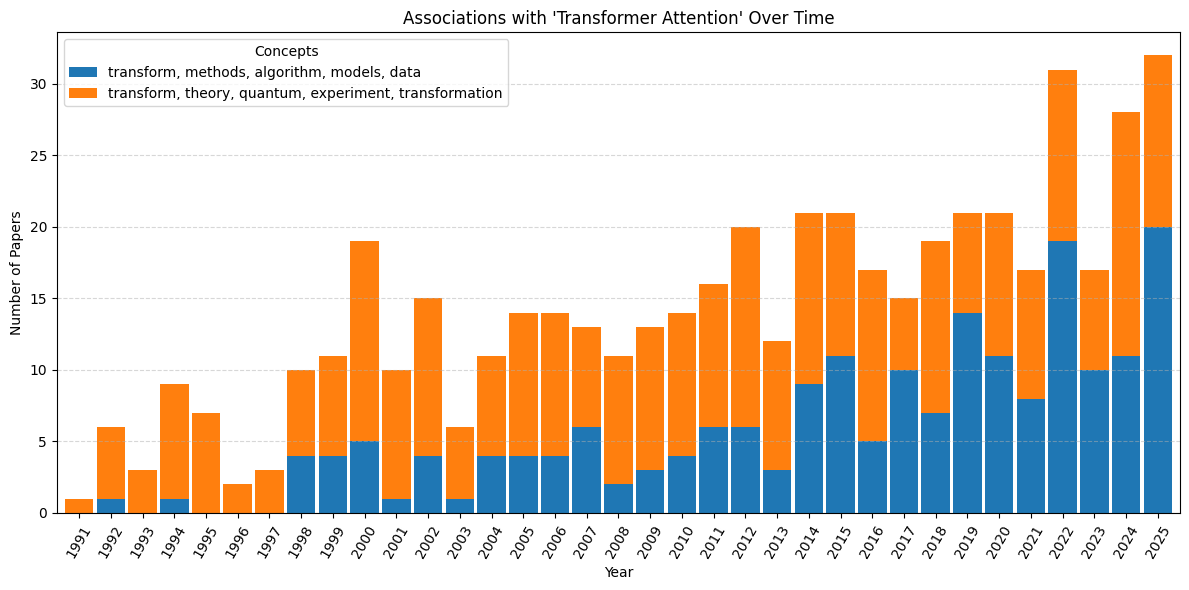

In [13]:
import matplotlib.pyplot as plt

def plot_concept_shifts(df: pd.DataFrame):
    counts = df.groupby(['year', 'cluster_label']).size().unstack(fill_value=0)
    counts.plot(kind='bar', stacked=True, figsize=(12, 6), width=0.9)

    plt.title(f"Associations with '{query}' Over Time")
    plt.legend(title="Concepts", loc='upper left')
    plt.xlabel("Year")
    plt.ylabel("Number of Papers")
    plt.xticks(rotation=60)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_concept_shifts(clustered_df)

We seem to be on the right track (notice how the ML-related cluster grows over time). However, we chose the number of clusters to be 2... how do we know what a "good" number of clusters should be? Look at what happens if we bump it to 5.

Clustering 500 papers into 5 concepts...
Generating cluster labels...


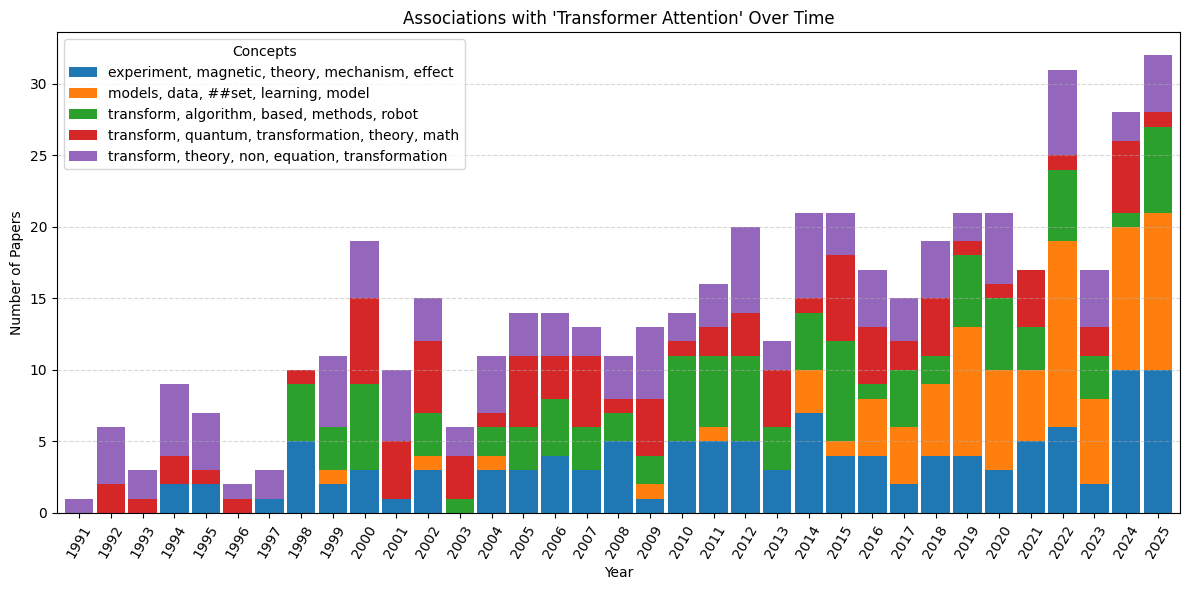

In [14]:
more_clusters_df, _ = analyze_concept_evolution(concept_results, n_clusters = 5)
plot_concept_shifts(more_clusters_df)

We can see that we get clusters that are not necessarily distinct from each other (e.g., "transform, quantum, transformation, theory, math" is likely the same as "experiment, magnetic theory, mechanism, effect") along with some unwanted "concepts" ("##set", "non").

### Determining the Optimal Number of Clusters

We can estimate a good number of clusters using a silhouette score. This measures how similar an object is to its own cluster relative to other clusters. The value ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. We can iterate through a range of `k` (e.g., 2 to 8) and choose the one that maximizes the Silhouette Score.

Evaluating cluster counts from 2 to 8...
Silhouette Scores:
	k=2: 0.0743
	k=3: 0.0551
	k=4: 0.0559
	k=5: 0.0570
	k=6: 0.0581
	k=7: 0.0595
	k=8: 0.0503
Re-running analysis with k=2...
	k=7: 0.0595
	k=8: 0.0503
Re-running analysis with k=2...
Clustering 500 papers into 2 concepts...
Generating cluster labels...
Clustering 500 papers into 2 concepts...
Generating cluster labels...


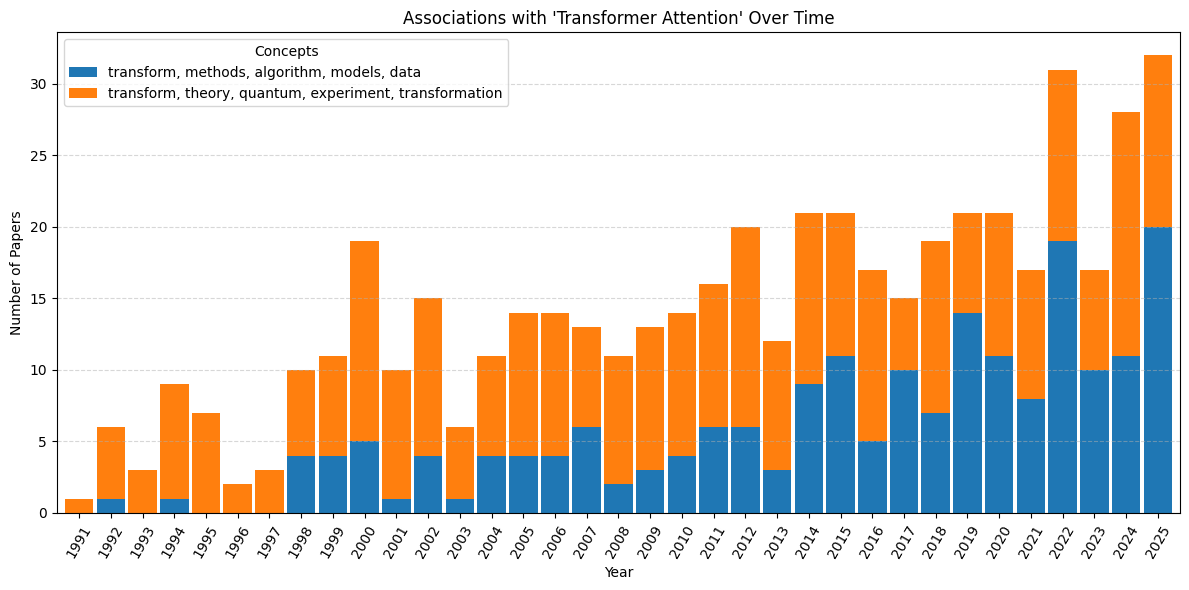

In [ ]:
from sklearn.metrics import silhouette_score

def optimize_cluster_count(search_results_df, max_k=8):
    if search_results_df.empty:
        return 2
        
    paper_ids = search_results_df['arxiv_id'].apply(hash_to_int64).tolist()
    res = collection.query(
        expr=f"paper_id in {paper_ids}",
        output_fields=["dense_vector"]
    )
    
    if not res:
        return 2
        
    vectors = [x['dense_vector'] for x in res]
    matrix = np.stack(vectors)
    
    scores = []
    ks = range(2, min(max_k + 1, len(matrix)))
    print(f"Evaluating cluster counts from {ks[0]} to {ks[-1]}...")
    print("Silhouette Scores:")
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(matrix)
        score = silhouette_score(matrix, labels)
        scores.append(score)
        print(f"\tk={k}: {score:.4f}")
        
    best_k = ks[np.argmax(scores)]
    return best_k


best_k = optimize_cluster_count(concept_results)
print(f"Re-running analysis with k={best_k}...")
final_df, final_labels = analyze_concept_evolution(concept_results, n_clusters=best_k)
plot_concept_shifts(final_df)